# Model Baseline and Schedule

This notebook will take you through the steps
1. Enable real-time inference data capture
2. Model Monitor - Baseling
3. Analyse initial monitoring schedule
4. Create monitoring schedule

## Step 1: Enable real-time inference data capture

To enable data capture for monitoring the model data quality, you specify the new capture option called `DataCaptureConfig`. 

You can capture the request payload, the response payload or both with this configuration. The capture config applies to all variants. Please provide the Endpoint name in the following cell:

In [10]:
from sagemaker.model_monitor import DataCaptureConfig
from sagemaker import RealTimePredictor
from sagemaker import session
import boto3

sm_session = session.Session(boto3.Session())
bucket = sm_session.default_bucket()
prefix='ludwig-model'

In [11]:
codepipeline = boto3.client('codepipeline')
sm = boto3.client('sagemaker')

pipeline_name = 'iris-train-pipeline'
training_job_name_mask='mlops-iris-model-%s'
endpoint_name_mask='mlops-iris-model-%s-%s'

# Get the current execution id for the latest succesful prod deploy
response = codepipeline.get_pipeline_state( name=pipeline_name )
executionId = response['stageStates'][-1]['latestExecution']['pipelineExecutionId']
endpoint_name = endpoint_name_mask % ('prd', executionId)
print('endpoint name: {}'.format(endpoint_name))

endpoint name: mlops-iris-model-prd-5edf6063-82ad-436c-a7bc-5406ac661139


In [14]:
s3_capture_prefix = '{}/datacapture'.format(prefix)
s3_capture_upload_path = 's3://{}/{}'.format(bucket, s3_capture_prefix)
print('data capture: {}'.format(s3_capture_upload_path))

data capture: s3://sagemaker-ap-southeast-2-691313291965/ludwig-model/datacapture


In [15]:
from sagemaker.model_monitor import DataCaptureConfig
from sagemaker import RealTimePredictor
from sagemaker import session
from sagemaker.utils import name_from_base

import boto3
sm_session = session.Session(boto3.Session())

# Change parameters as you would like - adjust sampling percentage, 
#  chose to capture request or response or both.
#  Learn more from our documentation
data_capture_config = DataCaptureConfig(
                        enable_capture = True,
                        sampling_percentage=100,
                        destination_s3_uri=s3_capture_upload_path,
                        kms_key_id=None,
                        capture_options=["REQUEST", "RESPONSE"],
                        csv_content_types=["text/csv"],
                        json_content_types=["application/json"])

# NOTE: The following doesn't work when created by CFN
# # Now it is time to apply the new configuration and wait for it to be applied
# predictor = RealTimePredictor(endpoint=endpoint_name)
# predictor.update_data_capture_config(data_capture_config=data_capture_config)
# sm_session.wait_for_endpoint(endpoint=endpoint_name)

endpoint = sm.describe_endpoint(EndpointName=endpoint_name)
if endpoint['EndpointStatus'] != 'InService':
    raise(Exception('Endpoint not InService'))

# Get the current endpoint config
endpoint_config_name = endpoint['EndpointConfigName']
new_config_name = name_from_base(base=endpoint_config_name)

# Create a new config from the existing adding data capture
new_tags = [{'Key': 'datacapture', 'Value': 'true'}] 
sm_session.create_endpoint_config_from_existing(
    endpoint_config_name, new_config_name, new_tags=new_tags, 
    new_data_capture_config_dict=data_capture_config._to_request_dict())

# Update the endpoint
sm_session.update_endpoint(endpoint_name=endpoint_name, endpoint_config_name=new_config_name)

-------------!

'mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38'

## Step 2: Model Monitor - Baseling

In addition to collecting the data, SageMaker allows you to monitor and evaluate the data observed by the Endpoints. 

For this :
1. We need to create a baseline with which we compare the realtime traffic against. 
1. Once a baseline is ready, we can setup a schedule to continously evaluate/compare against the baseline.

In [125]:
import pandas as pd

baseline_file = 'baselining/data/baseline.csv'
df_baseline = pd.read_csv('output/data/predictions.csv')
df_baseline.to_csv(baseline_file, index=False, float_format='%.10f') # Persist as floats to support baseline

In [22]:
!head -3 $baseline_file

class_predictions,class_probabilities_<UNK>,class_probabilities___label__eating_out,class_probabilities___label__groceries,class_probabilities___label__transport,class_probabilities___label__shopping,class_probabilities___label__health,class_probabilities___label__travel,class_probabilities___label__entertainment,class_probabilities___label__education,class_probabilities___label__home,class_probabilities___label__utilities,class_probability
__label__eating_out,0.0000001458,0.9999519587,0.0000055887,0.0000078400,0.0000031690,0.0000110159,0.0000074479,0.0000102731,0.0000000669,0.0000007465,0.0000017068,0.9999519587
__label__eating_out,0.0000000002,0.9999959469,0.0000025158,0.0000000159,0.0000000256,0.0000000323,0.0000000065,0.0000012531,0.0000000010,0.0000000378,0.0000002489,0.9999959469


### Constraint suggestion with baseline/training dataset

Use the output predictions from test dataset to upload as baseline

In [23]:
# copy over the training dataset to Amazon S3 (if you already have it in Amazon S3, you could reuse it)
baseline_prefix = prefix + '/baselining'
baseline_results_prefix = baseline_prefix + '/results'

baseline_data_uri = 's3://{}/{}'.format(bucket,baseline_file)
baseline_results_uri = 's3://{}/{}'.format(bucket, baseline_results_prefix)
print('Baseline data file: {}'.format(baseline_data_uri))
print('Baseline results uri: {}'.format(baseline_results_uri))

Baseline data file: s3://sagemaker-ap-southeast-2-691313291965/baselining/data/baseline.csv
Baseline results uri: s3://sagemaker-ap-southeast-2-691313291965/ludwig-model/baselining/results


In [24]:
boto3.Session().resource('s3').Bucket(bucket).Object(baseline_file).upload_file(baseline_file)
print('Uploaded baseline: {}'.format(baseline_file))

Uploaded baseline: baselining/data/baseline.csv


### Create a baselining job with the training dataset

Now that we have the training data ready in S3, let's kick off a job to `suggest` constraints. `DefaultModelMonitor.suggest_baseline(..)` kicks off a `ProcessingJob` using a SageMaker provided Model Monitor container to generate the constraints. Please edit the configurations to fit your needs.

In [ ]:
from sagemaker.model_monitor import DefaultModelMonitor
from sagemaker.model_monitor.dataset_format import DatasetFormat
from sagemaker import get_execution_role

role = get_execution_role()

my_default_monitor = DefaultModelMonitor(
    role=role,a
    instance_count=1,
    instance_type='ml.m5.xlarge',
    volume_size_in_gb=20,
    max_runtime_in_seconds=3600,
)

my_default_monitor.suggest_baseline(
    baseline_dataset=baseline_data_uri,
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=baseline_results_uri,
    wait=True
)


Job Name:  baseline-suggestion-job-2020-02-24-14-22-44-653
Inputs:  [{'InputName': 'baseline_dataset_input', 'S3Input': {'S3Uri': 's3://sagemaker-ap-southeast-2-691313291965/baselining/data/baseline.csv', 'LocalPath': '/opt/ml/processing/input/baseline_dataset_input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'monitoring_output', 'S3Output': {'S3Uri': 's3://sagemaker-ap-southeast-2-691313291965/ludwig-model/baselining/results', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
....

In [ ]:
# schedule_name = 'mlops-iris-model-prd-4650d8fb-8fde-4d44-a07b-9cf659725197'
# my_default_monitor = DefaultModelMonitor.attach(schedule_name)
# my_default_monitor.describe_schedule()

### Explore the generated constraints and statistics

In [ ]:
baseline_job = my_default_monitor.latest_baselining_job
schema_df = pd.io.json.json_normalize(baseline_job.baseline_statistics().body_dict["features"])
schema_df.head(10)

In [ ]:
constraints_df = pd.io.json.json_normalize(baseline_job.suggested_constraints().body_dict["features"])
constraints_df.head(10)

Before proceeding to enable monitoring, you could chose to edit the constraint file as required to fine tune the constraints.

## Step 3: Analyse initial monitoring schedule

We have collected the data above, here we proceed to analyze and monitor the data with MonitoringSchedules.

Start with sending some different data so that we can then process the data capture in monitoring

In [168]:
sm_runtime = boto3.client('sagemaker-runtime')

def test_endpoint(endpoint_name, payload):
    resp = sm_runtime.invoke_endpoint(
        EndpointName=endpoint_name,
        Body=payload,
        ContentType='text/csv'
    )
    return resp['Body'].read()

In [220]:
import pandas as pd

# Load sample data
monitor_sample = [
# Define some typical data
    'cool asian food pty melbourne au', # eathing out
    'woolworths 3188 brunswick au', # groceries
    'airbnb * blaa surry hills au', # travel
    'lido cinemas hawthorn au', # entertainment
    'northcote indoor spo thornbury au', # health
# Define some data which is out of bounds of usual sample
    'one',
    'one two',
    'one two three',
    '1',
    '2',
    '3',
    'fdkslfjkdlsjfkdsfkldjsklfmdskfjkdlsjfkldsjfkldsjfkldsjklfjsdkjfklds',
    'this is a very long sentance that should skew the character and word count',
]

In [225]:
header = ['text']
resp = ''

# Send off a series of invidual requests for each sample
from tqdm import tqdm
for i in tqdm(range(100)):
    for sample in monitor_sample:
        payload = '\n'.join(header+[sample]).encode('utf-8')
        resp += test_endpoint(endpoint_name, payload).decode('utf-8')
        
len(resp)


 49%|████▉     | 49/100 [00:15<00:16,  3.09it/s]

KeyboardInterrupt: 

To see if the drift reverts back to the baseline, send data from the original distribuition

In [148]:
import pandas as pd

df_test = pd.read_csv('input/data/test/test.csv')

print('sending {} validation records'.format(df_test.shape[0]))
payload = df_test[['text']].to_csv(index=False).encode('utf-8')
resp = test_endpoint(endpoint_name, payload).decode('utf-8')
resp[:100]

sending 293 validation records


'__label__eating_out,0.0000033515,0.9987571239,0.0000872765,0.0005289308,0.0001255432,0.0000869589,0.'

### Inspect Captured data

In [229]:
s3_client = boto3.Session().client('s3')

# Get capture files for this new endpoint
results_prefix = s3_capture_prefix+'/'+endpoint_name
result = s3_client.list_objects(Bucket=bucket, Prefix=results_prefix)
if not 'Contents' in result:
    raise(Exception('No results vailable yet for location: {}'.format(results_prefix)))
else:
    capture_files = ['s3://{0}/{1}'.format(bucket, capture_file.get("Key")) 
                     for capture_file in result.get('Contents')][::-1]
    print("Captured Files: {}, top 3:".format(len(capture_files)))
    print("\n ".join(capture_files[:3]))

Captured Files: 16, top 3:
s3://sagemaker-ap-southeast-2-691313291965/ludwig-model/datacapture/mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38/mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38/2020/02/24/22/52-46-400-2ba98ad6-4559-43b5-9861-da1116a5d60f.jsonl
 s3://sagemaker-ap-southeast-2-691313291965/ludwig-model/datacapture/mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38/mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38/2020/02/24/22/51-38-072-8b7d0adf-bf7f-4845-8f4c-3a7c8da33a29.jsonl
 s3://sagemaker-ap-southeast-2-691313291965/ludwig-model/datacapture/mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38/mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38/2020/02/24/21/53-38-857-5c73de1c-5d2b-47ac-b930-1a68943f955c.jsonl


In [230]:
!mkdir -p baselining/output
!aws s3 cp {capture_files[1]} baselining/output/captured_data_example.jsonl
!head -1 baselining/output/captured_data_example.jsonl

download: s3://sagemaker-ap-southeast-2-691313291965/ludwig-model/datacapture/mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38/mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38/2020/02/24/22/51-38-072-8b7d0adf-bf7f-4845-8f4c-3a7c8da33a29.jsonl to baselining/output/captured_data_example.jsonl
{"captureData":{"endpointInput":{"observedContentType":"text/csv","mode":"INPUT","data":"text\nlocal gastown vancouver ca\npadre coffee brunswick easau\n","encoding":"CSV"},"endpointOutput":{"observedContentType":"text/csv","mode":"OUTPUT","data":"__label__eating_out,0.0000033515,0.9987571239,0.0000872765,0.0005289308,0.0001255432,0.0000869589,0.0002310269,0.0000628455,0.0000033226,0.0000436031,0.0000702098,0.9987571239\n__label__eating_out,0.0000000038,0.9999557734,0.0000285508,0.0000015725,0.0000011309,0.0000003446,0.0000002136,0.0000047278,0.0000000428,0.0000021473,0.0000055087,0.9999557734\n","encoding":"CSV"}},"eventMetadata":{"eventId":"11bf4b05-ca8c-40b7-a61a-37ce5c63c1ee","

Write the first payload from this line

In [227]:
import json

def parse_event_output(data):
    import csv
    from io import StringIO
    cols = ['class_predictions',
             'class_probabilities_<UNK>',
             'class_probabilities___label__eating_out',
             'class_probabilities___label__groceries',
             'class_probabilities___label__transport',
             'class_probabilities___label__shopping',
             'class_probabilities___label__health',
             'class_probabilities___label__travel',
             'class_probabilities___label__entertainment',
             'class_probabilities___label__education',
             'class_probabilities___label__home',
             'class_probabilities___label__utilities',
             'class_probability']
    for row in csv.DictReader(StringIO(data), fieldnames=cols):
        return dict(row) # Return first row only, or return list of dicts?

with open('baselining/output/captured_data_example.jsonl', 'r') as f:
    lines = f.read().split('\n')
    event = json.loads(lines[0])
    print('input: {}\n{}'.format(event['captureData']['endpointInput']['observedContentType'], 
                                 event['captureData']['endpointInput']['data'][:200]))
    print('output: {}\n{}'.format(event['captureData']['endpointOutput']['observedContentType'], 
                                  parse_event_output(event['captureData']['endpointOutput']['data'])))

input: text/csv
text
local gastown vancouver ca
padre coffee brunswick easau

output: text/csv
{'class_predictions': '__label__eating_out', 'class_probabilities_<UNK>': '0.0000033515', 'class_probabilities___label__eating_out': '0.9987571239', 'class_probabilities___label__groceries': '0.0000872765', 'class_probabilities___label__transport': '0.0005289308', 'class_probabilities___label__shopping': '0.0001255432', 'class_probabilities___label__health': '0.0000869589', 'class_probabilities___label__travel': '0.0002310269', 'class_probabilities___label__entertainment': '0.0000628455', 'class_probabilities___label__education': '0.0000033226', 'class_probabilities___label__home': '0.0000436031', 'class_probabilities___label__utilities': '0.0000702098', 'class_probability': '0.9987571239'}


### Run an immediate schedule

Lets start by running a schedule on some drifted data.

In [216]:
import os, sys
from urllib.parse import urlparse
from sagemaker.processing import Processor, ProcessingInput, ProcessingOutput

def get_model_monitor_container_uri(region):
    container_uri_format = '{0}.dkr.ecr.{1}.amazonaws.com/sagemaker-model-monitor-analyzer'
    
    regions_to_accounts = {
        'eu-north-1': '895015795356',
        'me-south-1': '607024016150',
        'ap-south-1': '126357580389',
        'us-east-2': '680080141114',
        'us-east-2': '777275614652',
        'eu-west-1': '468650794304',
        'eu-central-1': '048819808253',
        'sa-east-1': '539772159869',
        'ap-east-1': '001633400207',
        'us-east-1': '156813124566',
        'ap-northeast-2': '709848358524',
        'eu-west-2': '749857270468',
        'ap-northeast-1': '574779866223',
        'us-west-2': '159807026194',
        'us-west-1': '890145073186',
        'ap-southeast-1': '245545462676',
        'ap-southeast-2': '563025443158',
        'ca-central-1': '536280801234'
    }
    
    container_uri = container_uri_format.format(regions_to_accounts[region], region)
    return container_uri

def get_file_name(url):
    a = urlparse(url)
    return os.path.basename(a.path)

def run_model_monitor_job_processor(region, instance_type, role, data_capture_path, statistics_path, constraints_path, reports_path,
                                    instance_count=1, preprocessor_path=None, postprocessor_path=None, publish_cloudwatch_metrics='Disabled'):
    
    data_capture_sub_path = data_capture_path[data_capture_path.rfind('datacapture/') :]
    data_capture_sub_path = data_capture_sub_path[data_capture_sub_path.find('/') + 1 :]
    processing_output_paths = reports_path + '/' + data_capture_sub_path
    
    input_1 = ProcessingInput(input_name='input_1',
                          source=data_capture_path,
                          destination='/opt/ml/processing/input/endpoint/' + data_capture_sub_path,
                          s3_data_type='S3Prefix',
                          s3_input_mode='File')

    baseline = ProcessingInput(input_name='baseline',
                               source=statistics_path,
                               destination='/opt/ml/processing/baseline/stats',
                               s3_data_type='S3Prefix',
                               s3_input_mode='File')

    constraints = ProcessingInput(input_name='constraints',
                                  source=constraints_path,
                                  destination='/opt/ml/processing/baseline/constraints',
                                  s3_data_type='S3Prefix',
                                  s3_input_mode='File')

    outputs = ProcessingOutput(output_name='result',
                               source='/opt/ml/processing/output',
                               destination=processing_output_paths,
                               s3_upload_mode='Continuous')

    env = {'baseline_constraints': '/opt/ml/processing/baseline/constraints/' + get_file_name(constraints_path),
           'baseline_statistics': '/opt/ml/processing/baseline/stats/' + get_file_name(statistics_path),
           'dataset_format': '{"sagemakerCaptureJson":{"captureIndexNames":["endpointInput","endpointOutput"]}}',
           'dataset_source': '/opt/ml/processing/input/endpoint',
           'output_path': '/opt/ml/processing/output',
           'publish_cloudwatch_metrics': publish_cloudwatch_metrics }
    
    inputs=[input_1, baseline, constraints]
    
    if postprocessor_path:
        env['post_analytics_processor_script'] = '/opt/ml/processing/code/postprocessing/' + get_file_name(postprocessor_path)
        
        post_processor_script = ProcessingInput(input_name='post_processor_script',
                                                source=postprocessor_path,
                                                destination='/opt/ml/processing/code/postprocessing',
                                                s3_data_type='S3Prefix',
                                                s3_input_mode='File')
        inputs.append(post_processor_script)

    if preprocessor_path:
        env['record_preprocessor_script'] = '/opt/ml/processing/code/preprocessing/' + get_file_name(preprocessor_path)
         
        pre_processor_script = ProcessingInput(input_name='pre_processor_script',
                                               source=preprocessor_path,
                                               destination='/opt/ml/processing/code/preprocessing',
                                               s3_data_type='S3Prefix',
                                               s3_input_mode='File')
        
        inputs.append(pre_processor_script) 
    
    processor = Processor(image_uri = get_model_monitor_container_uri(region),
                          instance_count = instance_count,
                          instance_type = instance_type,
                          role=role,
                          env = env)
    
    return processor.run(inputs=inputs, outputs=[outputs])

In [ ]:
%%writefile preprocessor.py
import json 

import json

def parse_event_output(data):
    import csv
    from io import StringIO
    cols = ['class_predictions',
             'class_probabilities_<UNK>',
             'class_probabilities___label__eating_out',
             'class_probabilities___label__groceries',
             'class_probabilities___label__transport',
             'class_probabilities___label__shopping',
             'class_probabilities___label__health',
             'class_probabilities___label__travel',
             'class_probabilities___label__entertainment',
             'class_probabilities___label__education',
             'class_probabilities___label__home',
             'class_probabilities___label__utilities',
             'class_probability'] # Define columns
    for row in csv.DictReader(StringIO(data), fieldnames=cols):
        return dict(row) # Return first row only, or is a list supported

def preprocess_handler(inference_record):
    try:
        # Parse the CSV with header
        data = inference_record.endpoint_output.data
        if inference_record.endpoint_output.encoding == 'CSV':
            data = parse_event_output(data)
        return data
    except:
        # Return an undefined label
        return {'class_predictions': '__label__undefined', 'class_probabilities_<UNK>': 1.0 }

In [ ]:
%%writefile postprocessor.py
def postprocess_handler():
    print("Hello from post-proc script!")

In [ ]:
import boto3

monitoring_code_prefix = '{0}/monitoring/code'.format(prefix)
print(monitoring_code_prefix)

boto3.Session().resource('s3').Bucket(bucket).Object(monitoring_code_prefix + '/preprocessor.py').upload_file('preprocessor.py')
s3_preprocessor_path = 's3://{0}/{1}/monitoring/code/preprocessor.py'.format(bucket, prefix)
print(s3_preprocessor_path)

boto3.Session().resource('s3').Bucket(bucket).Object(monitoring_code_prefix + '/postprocessor.py').upload_file('postprocessor.py')
s3_postprocessor_path = 's3://{0}/{1}/monitoring/code/postprocessor.py'.format(bucket, prefix)
print(s3_postprocessor_path)

s3_reports_path = 's3://{0}/{1}/monitoring/reports'.format(bucket, prefix)
print(s3_reports_path)

In [ ]:
# Pick the last statistics/contstraints from capture files
s3_data_capture_path = capture_files[len(capture_files) - 1][: capture_files[len(capture_files) - 1].rfind('/')]
s3_statistics_path = baseline_results_uri + '/statistics.json'
s3_constraints_path = baseline_results_uri + '/constraints.json'

print(s3_data_capture_path)
print(s3_postprocessor_path)
print(s3_statistics_path)
print(s3_constraints_path)
print(s3_reports_path)

In [219]:
region = boto3.Session().region_name

processor = run_model_monitor_job_processor(region, 'ml.m5.xlarge', role, 
                                s3_data_capture_path, s3_statistics_path, s3_constraints_path, s3_reports_path,
                                #preprocessor_path=s3_preprocessor_path,
                                postprocessor_path=s3_postprocessor_path)

### Analysis

When the monitoring job completes, monitoring reports are saved to Amazon S3. Let's list the generated reports.

In [95]:
s3_client = boto3.Session().client('s3')
monitoring_reports_prefix = '{}/monitoring/reports/{}'.format(prefix, endpoint_name)

result = s3_client.list_objects(Bucket=bucket, Prefix=monitoring_reports_prefix)
try:
    monitoring_reports = ['s3://{0}/{1}'.format(bucket, capture_file.get("Key")) for capture_file in result.get('Contents')]
    print("Monitoring Reports Files: ")
    print("\n ".join(monitoring_reports))
except:
    print('No monitoring reports found.')

Monitoring Reports Files: 
s3://sagemaker-ap-southeast-2-691313291965/ludwig-model/monitoring/reports/mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38/mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38/2020/02/24/13/constraint_violations.json
 s3://sagemaker-ap-southeast-2-691313291965/ludwig-model/monitoring/reports/mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38/mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38/2020/02/24/13/constraints.json
 s3://sagemaker-ap-southeast-2-691313291965/ludwig-model/monitoring/reports/mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38/mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38/2020/02/24/13/statistics.json
 s3://sagemaker-ap-southeast-2-691313291965/ludwig-model/monitoring/reports/mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38/mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38/2020/02/24/15/constraint_violations.json
 s3://sagemaker-ap-southeast-2-691313291965/ludwig-model/monito

Copy monitoring reports locally

In [96]:
!aws s3 cp {monitoring_reports[0]} monitoring/
!aws s3 cp {monitoring_reports[1]} monitoring/
!aws s3 cp {monitoring_reports[2]} monitoring/

download: s3://sagemaker-ap-southeast-2-691313291965/ludwig-model/monitoring/reports/mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38/mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38/2020/02/24/13/constraint_violations.json to monitoring/constraint_violations.json
download: s3://sagemaker-ap-southeast-2-691313291965/ludwig-model/monitoring/reports/mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38/mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38/2020/02/24/13/constraints.json to monitoring/constraints.json
download: s3://sagemaker-ap-southeast-2-691313291965/ludwig-model/monitoring/reports/mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38/mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38/2020/02/24/13/statistics.json to monitoring/statistics.json


In [97]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

file = open('monitoring/constraint_violations.json', 'r')
data = file.read()

violations_df = pd.io.json.json_normalize(json.loads(data)['violations'])
violations_df

,constraint_check_type,description,feature_name
0,completeness_check,Data completeness requirement is not met. Expected: 100.0%. Observed: Only 50.0%.,class_probabilities___label__utilities
1,completeness_check,Data completeness requirement is not met. Expected: 100.0%. Observed: Only 50.0%.,class_probabilities___label__home
2,completeness_check,Data completeness requirement is not met. Expected: 100.0%. Observed: Only 50.0%.,class_probability
3,data_type_check,"Data type match requirement is not met. Expected data type: String, Expected match: 100.0%. Observed: Only 50.0% of data is String.",class_predictions
4,categorical_values_check,Categorical value match requirement is not met. Expected match: 100.0%. Observed: 50.0% of the values match the known values.,class_predictions


### Advanced Hints

You might be asking yourself what are the type of violations that are monitored and how drift from the baseline is computed.

The types of violations monitored are listed here: https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-interpreting-violations.html. Most of them use configurable thresholds, that are specified in the monitoring configuration section of the baseline constraints JSON. Let's take a look at this configuration from the baseline constraints file:

In [ ]:
!aws s3 cp {statistics_path} baseline/
!aws s3 cp {constraints_path} baseline/

In [ ]:
import json
with open ("baseline/constraints.json", "r") as myfile:
    data=myfile.read()

print(json.dumps(json.loads(data)['monitoring_config'], indent=2))

This configuration is intepreted when the monitoring job is executed and used to compare captured data to the baseline. If you want to customize this section, you will have to update the constraints.json file and upload it back to Amazon S3 before launching the monitoring job.

When data distributions are compared to detect potential drift, you can choose to use either a Simple or Robust comparison method, where the latter has to be preferred when dealing with small datasets. Additional info: https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-byoc-constraints.html.

## Step 4. Create a schedule

We are ready to create a model monitoring schedule for the Endpoint created earlier with the baseline resources (constraints and statistics).

In [ ]:
from sagemaker.model_monitor import CronExpressionGenerator
from time import gmtime, strftime

mon_schedule_name = endpoint_name # Create the mon schedule based on endpoint name

my_default_monitor.create_monitoring_schedule(
    monitor_schedule_name=endpoint_name,
    endpoint_input=endpoint_name,
    output_s3_uri=s3_reports_path,
    statistics=my_default_monitor.baseline_statistics(),
    constraints=my_default_monitor.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True,
)

In [ ]:
print('Schedule status: {}'.format(my_default_monitor.describe_schedule()['MonitoringScheduleStatus']))

### List Executions

The schedule starts jobs at the previously specified intervals. Here, you list the latest five executions. Note that if you are kicking this off after creating the hourly schedule, you might find the executions empty. You might have to wait until you cross the hour boundary (in UTC) to see executions kick off. The code below has the logic for waiting.

Note: Even for an hourly schedule, Amazon SageMaker has a buffer period of 20 minutes to schedule your execution. You might see your execution start in anywhere from zero to ~20 minutes from the hour boundary. This is expected and done for load balancing in the backend.

In [231]:
!aws sagemaker list-processing-jobs --max-item 1

{
    "ProcessingJobSummaries": [
        {
            "ProcessingJobName": "model-monitoring-202002250200-7fddbfd8ed9e7afc5e315355",
            "ProcessingJobArn": "arn:aws:sagemaker:ap-southeast-2:691313291965:processing-job/model-monitoring-202002250200-7fddbfd8ed9e7afc5e315355",
            "CreationTime": 1582596559.576,
            "ProcessingEndTime": 1582596753.0,
            "LastModifiedTime": 1582596753.114,
            "ProcessingJobStatus": "Failed",
            "FailureReason": "ClientError: Failed to download data. S3 key: s3://sagemaker-ap-southeast-2-691313291965/mlops/datacapture/mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38/mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38/2020/02/25/01 matched no files on s3"
        }
    ],
    "NextToken": "eyJOZXh0VG9rZW4iOiBudWxsLCAiYm90b190cnVuY2F0ZV9hbW91bnQiOiAxfQ=="
}


In [232]:
!aws sagemaker list-monitoring-schedules --max-item 3

{
    "MonitoringScheduleSummaries": [
        {
            "MonitoringScheduleName": "mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d6-1582598782-b38b",
            "MonitoringScheduleArn": "arn:aws:sagemaker:ap-southeast-2:691313291965:monitoring-schedule/mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d6-1582598782-b38b",
            "CreationTime": 1582598782.274,
            "LastModifiedTime": 1582598787.246,
            "MonitoringScheduleStatus": "Scheduled",
            "EndpointName": "mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38"
        }
    ]
}


In [234]:
!aws sagemaker list-monitoring-executions  --monitoring-schedule-name $endpoint_name --max-item 1

{
    "MonitoringExecutionSummaries": [
        {
            "MonitoringScheduleName": "mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38",
            "ScheduledTime": 1582596000.0,
            "CreationTime": 1582596556.509,
            "LastModifiedTime": 1582596756.182,
            "MonitoringExecutionStatus": "Failed",
            "ProcessingJobArn": "arn:aws:sagemaker:ap-southeast-2:691313291965:processing-job/model-monitoring-202002250200-7fddbfd8ed9e7afc5e315355",
            "EndpointName": "mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38",
            "FailureReason": "ClientError: Failed to download data. S3 key: s3://sagemaker-ap-southeast-2-691313291965/mlops/datacapture/mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38/mlops-iris-model-prd-8b5901b7-6769-4bba-841e-d60c39bf6d38/2020/02/25/01 matched no files on s3"
        }
    ],
    "NextToken": "eyJOZXh0VG9rZW4iOiBudWxsLCAiYm90b190cnVuY2F0ZV9hbW91bnQiOiAxfQ=="
}


In [159]:
import time

mon_executions = my_default_monitor.list_executions()
print("We created a hourly schedule above and it will kick off executions ON the hour (plus 0 - 20 min buffer).")
print("We will have to wait till we hit the hour...")

while len(mon_executions) == 0:
    time.sleep(30)
    print("Waiting for the 1st execution to happen...")
    mon_executions = my_default_monitor.list_executions()

We created a hourly schedule above and it will kick off executions ON the hour (plus 0 - 20 min buffer).
We will have to wait till we hit the hour...


### Inspect a specific execution (latest execution)
In the previous cell, you picked up the latest completed or failed scheduled execution. Here are the possible terminal states and what each of them mean: 
* Completed - This means the monitoring execution completed and no issues were found in the violations report.
* CompletedWithViolations - This means the execution completed, but constraint violations were detected.
* Failed - The monitoring execution failed, maybe due to client error (perhaps incorrect role premissions) or infrastructure issues. Further examination of FailureReason and ExitMessage is necessary to identify what exactly happened.
* Stopped - job exceeded max runtime or was manually stopped.

In [235]:
mon_executions = my_default_monitor.list_executions()

# get the latest completed schedule
for execution in mon_executions[::-1]:
    latest_job = execution.describe()
    print('{:%Y-%m-%d %H:%M} {}\n{}'.format(latest_job['ProcessingEndTime'], 
                                            latest_job['ProcessingJobStatus'],
                                            latest_job['ProcessingJobArn']))
    if latest_job['ProcessingJobStatus'] == 'Completed':
        break
    time.sleep(1)
           
if latest_job['ProcessingJobStatus'] == 'Completed':
    execution.wait(logs=False)
    print("Latest execution result: {}".format(latest_job['ExitMessage']))
else:
    print("====STOP====\nNo completed executions to inspect further. \nPlease wait till an execution completes or investigate previously reported failures.")

2020-02-25 02:12 Failed
arn:aws:sagemaker:ap-southeast-2:691313291965:processing-job/model-monitoring-202002250200-7fddbfd8ed9e7afc5e315355
2020-02-25 01:12 Failed
arn:aws:sagemaker:ap-southeast-2:691313291965:processing-job/model-monitoring-202002250100-1b63c0cb8518373fd3133282
2020-02-25 00:13 Completed
arn:aws:sagemaker:ap-southeast-2:691313291965:processing-job/model-monitoring-202002250000-722504343ca4f1f695cec195
!Latest execution result: CompletedWithViolations: Job completed successfully with 16 violations.


### Visualize the schedule

In [236]:
from IPython.display import HTML, display
import json
import os
import boto3

import sagemaker
from sagemaker import session
from sagemaker.model_monitor import MonitoringExecution
from sagemaker.s3 import S3Downloader

In [237]:
!wget -O utils.py https://raw.githubusercontent.com/awslabs/amazon-sagemaker-examples/master/sagemaker_model_monitor/visualization/utils.py

import utils as mu

--2020-02-25 03:56:00--  https://raw.githubusercontent.com/awslabs/amazon-sagemaker-examples/master/sagemaker_model_monitor/visualization/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.28.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.28.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12655 (12K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]  12.36K  --.-KB/s    in 0s      

2020-02-25 03:56:00 (96.2 MB/s) - ‘utils.py’ saved [12655/12655]



In [238]:
# processing_job_arn = latest_job['ProcessingJobArn']
# execution = MonitoringExecution.from_processing_arn(sagemaker_session=session.Session(), processing_job_arn=processing_job_arn)

In [239]:
execution.describe()['ExitMessage']

'CompletedWithViolations: Job completed successfully with 16 violations.'

In [240]:
exec_inputs = {inp['InputName']: inp for inp in execution.describe()['ProcessingInputs']}
exec_results = execution.output.destination

In [241]:
baseline_statistics_filepath = exec_inputs['baseline']['S3Input']['S3Uri'] if 'baseline' in exec_inputs else None
execution_statistics_filepath = os.path.join(exec_results, 'statistics.json')
violations_filepath = os.path.join(exec_results, 'constraint_violations.json')

baseline_statistics = json.loads(S3Downloader.read_file(baseline_statistics_filepath)) if baseline_statistics_filepath is not None else None
execution_statistics = json.loads(S3Downloader.read_file(execution_statistics_filepath))
violations = json.loads(S3Downloader.read_file(violations_filepath))['violations']

## Overview

The code below shows the violations and constraichecks across all features in a simple table.

In [243]:
mu.show_violation_df(baseline_statistics=baseline_statistics, latest_statistics=execution_statistics, violations=violations)

,data_type,completeness,baseline_drift,categorical_values
class_predictions,String,97.86%,44.36%,N/A
class_probabilities_,Fractional,100.00%,58.43%,N/A
class_probabilities___label__eating_out,Fractional,100.00%,17.40%,N/A
class_probabilities___label__education,Fractional,100.00%,58.01%,N/A
class_probabilities___label__entertainment,Fractional,100.00%,32.52%,N/A
class_probabilities___label__groceries,Fractional,100.00%,38.77%,N/A
class_probabilities___label__health,Fractional,100.00%,45.85%,N/A
class_probabilities___label__home,Fractional,17.40%,N/A,N/A
class_probabilities___label__shopping,Fractional,100.00%,29.44%,N/A
class_probabilities___label__transport,Fractional,100.00%,26.80%,N/A


## Distributions

This section visualizes the distribution and renders the distribution statistics for all features

,num_present,num_missing,mean,sum,std_dev,min,max
class_probabilities_<UNK>,1306,0,0.036205,47.284029,4.082800e-02,1.373700e-06,0.124787
class_probabilities___label__eating_out,1306,0,0.041647,54.390415,6.766435e-02,1.957000e-07,0.998757
class_probabilities___label__groceries,1306,0,0.094823,123.838483,2.619741e-01,5.250000e-08,0.999868
class_probabilities___label__transport,1306,0,0.114313,149.293094,2.558476e-01,6.400000e-09,0.996017
class_probabilities___label__shopping,1306,0,0.035557,46.436822,3.790597e-02,1.600000e-09,0.102824
class_probabilities___label__health,1306,0,0.089912,117.424772,2.624699e-01,1.770000e-08,0.998542
class_probabilities___label__travel,1306,0,0.017179,22.435423,3.231457e-02,7.000000e-09,0.996017
class_probabilities___label__entertainment,1306,0,0.024383,31.843740,2.581741e-02,8.100000e-09,0.063283
class_probabilities___label__education,1306,0,0.607845,793.846203,3.669745e-01,3.322600e-06,0.999998
class_probabilities___label__home,234,1072,0.715335,167.388462,2.775592e-01,2.754450e-05,0.998542


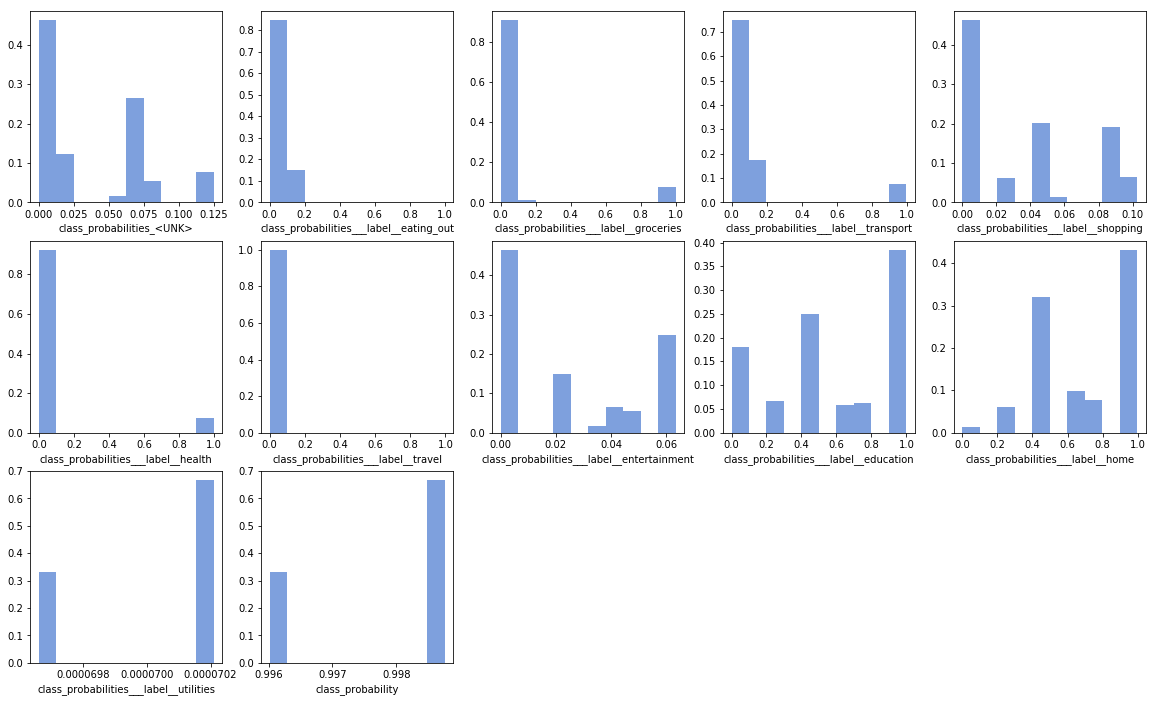

,num_present,num_missing,distinct_count
class_predictions,1279,27,31.0


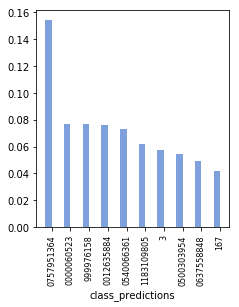

In [72]:
features = mu.get_features(execution_statistics)
feature_baselines = mu.get_features(baseline_statistics)
mu.show_distributions(features)

### Execution Stats vs Baseline

,num_present,num_missing,mean,sum,std_dev,min,max
class_probabilities_<UNK>,1306,0,0.036205,47.284029,4.082800e-02,1.373700e-06,0.124787
class_probabilities___label__eating_out,1306,0,0.041647,54.390415,6.766435e-02,1.957000e-07,0.998757
class_probabilities___label__groceries,1306,0,0.094823,123.838483,2.619741e-01,5.250000e-08,0.999868
class_probabilities___label__transport,1306,0,0.114313,149.293094,2.558476e-01,6.400000e-09,0.996017
class_probabilities___label__shopping,1306,0,0.035557,46.436822,3.790597e-02,1.600000e-09,0.102824
class_probabilities___label__health,1306,0,0.089912,117.424772,2.624699e-01,1.770000e-08,0.998542
class_probabilities___label__travel,1306,0,0.017179,22.435423,3.231457e-02,7.000000e-09,0.996017
class_probabilities___label__entertainment,1306,0,0.024383,31.843740,2.581741e-02,8.100000e-09,0.063283
class_probabilities___label__education,1306,0,0.607845,793.846203,3.669745e-01,3.322600e-06,0.999998
class_probabilities___label__home,234,1072,0.715335,167.388462,2.775592e-01,2.754450e-05,0.998542


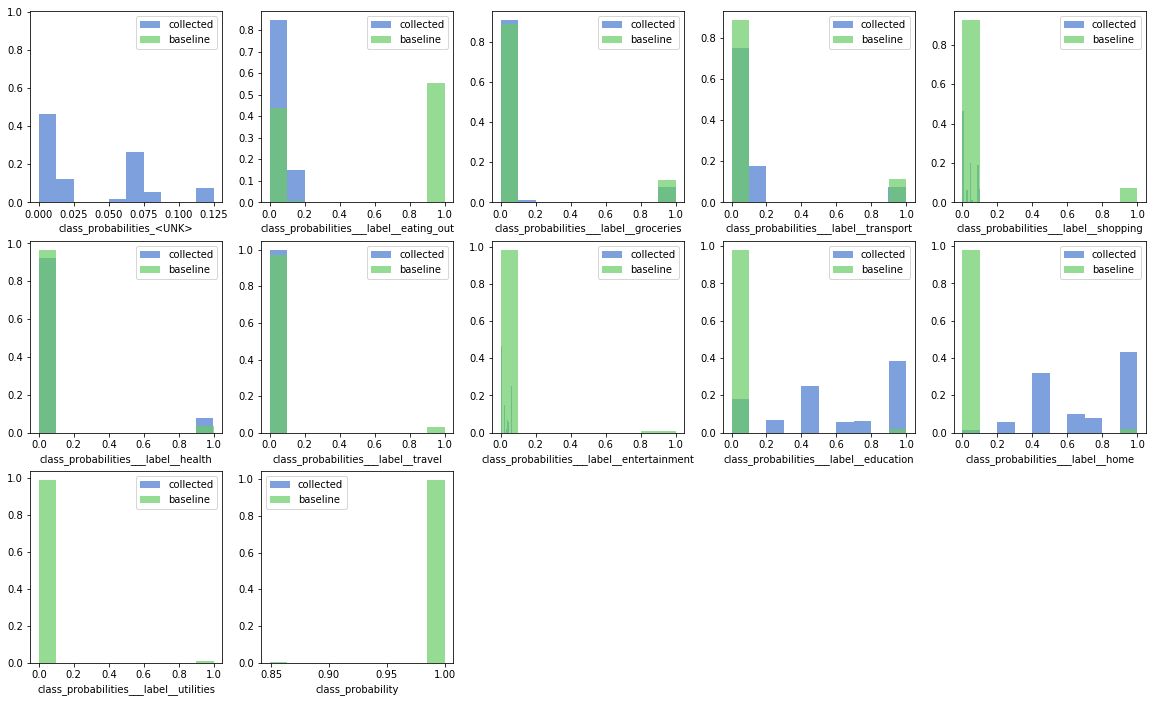

,num_present,num_missing,distinct_count
class_predictions,1279,27,31.0


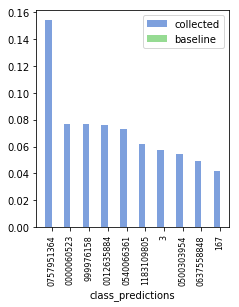

In [73]:
mu.show_distributions(features, feature_baselines)